# PLQE ANALYSIS

In [1]:
from analysis_functions import *

In [2]:
datapath = r" "
laser_range = (430, 480)
PL_range = (690,1000)
fuature_correction_cutoff = 600
power_at_1sun = 0.0007

# optional stuff
bandgap = 1.5
auto_bandgap = True # overwrites bandgap

## Load and process data:

In [3]:
measurement_db = load_data(datapath, fuature_correction_cutoff) 
powers,PLQE,PLQE_noout = calculate_PLQE(measurement_db, laser_range, PL_range)

if auto_bandgap:
    PL_range_index = (np.argmin(abs(measurement_db["in_empty_subtracted"][2][-1][:,0] - PL_range[0])),
                     np.argmin(abs(measurement_db["in_empty_subtracted"][2][-1][:,0] - PL_range[1])))
    
    wavel_peak_index = np.argmax(measurement_db["in_empty_subtracted"][2][-1][PL_range_index[0]:
                                                                              PL_range_index[1],1])
    
    wavel_peak = measurement_db["in_empty_subtracted"][2][-1][:,0] [wavel_peak_index + PL_range_index[0]]
    
    bandgap = sci.h * sci.c / (wavel_peak*1e-9*sci.e)
    print(f"Using optical bandgap of: {bandgap}eV")
else:
    print(f"Using specified bandgap of: {bandgap}eV")

Using optical bandgap of: 1.5112861509427917eV


D:\Scripts\intensity-dependent-PL\analysis\analysis_functions.py:112: RuntimeWarning: divide by zero encountered in log
  peaks, properties = find_peaks(np.log(short_datas[len(power)-2][:,1]),
D:\Scripts\intensity-dependent-PL\analysis\analysis_functions.py:112: RuntimeWarning: invalid value encountered in log
  peaks, properties = find_peaks(np.log(short_datas[len(power)-2][:,1]),


## Plot PL

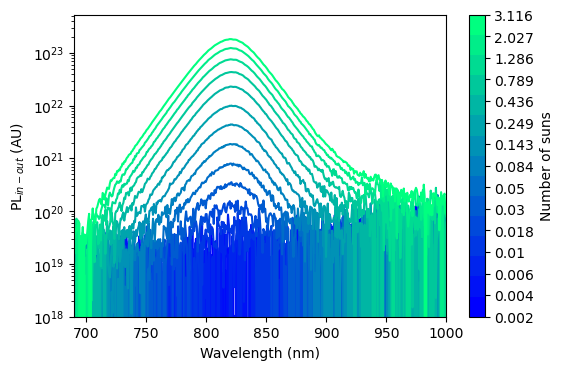

In [4]:
powers = measurement_db["in_empty_subtracted"][0]

cmap = mpl.cm.get_cmap('winter', len(powers))
c = np.arange(1, len(powers) + 1)

fig, ax = plt.subplots(dpi=100)
dummie_cax = ax.scatter(c, c, c=c, cmap=cmap)
ax.cla()

for i in range(len(measurement_db["in_empty_subtracted"][0])):  
    ax.plot(measurement_db["in_empty_subtracted"][2][i][:,0], 
            measurement_db["in_empty_subtracted"][2][i][:,1] - measurement_db["out_empty_subtracted"][2][i][:,1], 
            color=cmap(i))
ax.set_xlim(PL_range) # feel free to change this
plt.yscale('log')


ax.set_ylim(1e18) # Lower limit, CHANGE THIS AS NEEDED
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('PL$_{in - out}$ (AU)')

cbar = plt.colorbar(dummie_cax, ticks=c)
cbar.ax.set_yticklabels([round(i, 3) for i in powers/power_at_1sun])
cbar.ax.set_ylabel("Number of suns")

plt.show()

## Plot PLQE

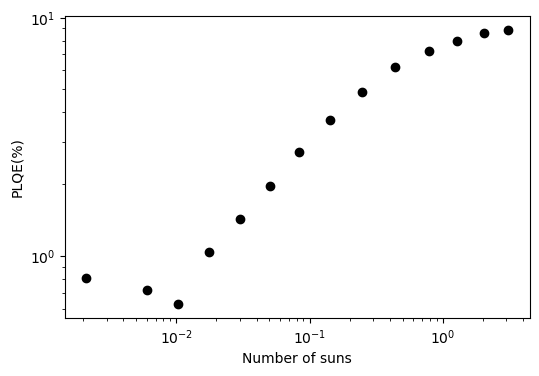

In [5]:
num_suns = powers / power_at_1sun

fig, ax = plt.subplots(dpi=100)
ax.scatter(num_suns, PLQE*100, color='k')
plt.xscale('log')
plt.yscale('log')

ax.set_xlabel('Number of suns')
ax.set_ylabel("PLQE(%)")

plt.show()

## Plot QFLS 

C:\Users\akashdasgupta\AppData\Local\Temp\ipykernel_26096\181578090.py:6: RuntimeWarning: invalid value encountered in log
  QFLSs = voc_rads + (sci.k * 298 / sci.e)*np.log(PLQE)


Text(0, 0.5, 'QFLS (eV)')

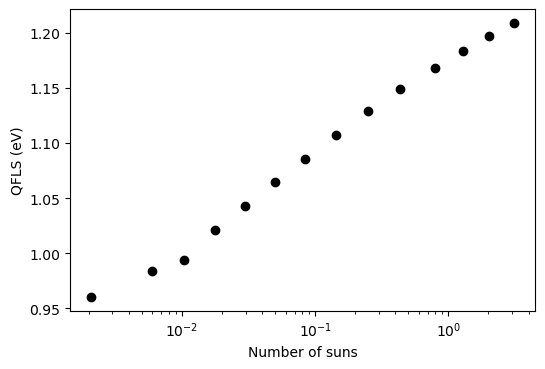

In [6]:
num_suns = powers / power_at_1sun
voc_rad0 = vocradf(bandgap)
jsc_by_j0 = np.exp(sci.e*voc_rad0/(sci.k*298))-1
voc_rads = (sci.k*298/sci.e)*np.log((jsc_by_j0*num_suns)+1)

QFLSs = voc_rads + (sci.k * 298 / sci.e)*np.log(PLQE)


fig, ax = plt.subplots(dpi=100)
ax.scatter(num_suns, QFLSs, color='k')
plt.xscale('log')


ax.set_xlabel('Number of suns')
ax.set_ylabel("QFLS (eV)")

## Plot Psudo JV

C:\Users\akashdasgupta\AppData\Local\Temp\ipykernel_26096\1049974419.py:9: RuntimeWarning: invalid value encountered in log
  QFLSs = voc_rads + (sci.k * 298 / sci.e)*np.log(PLQE)


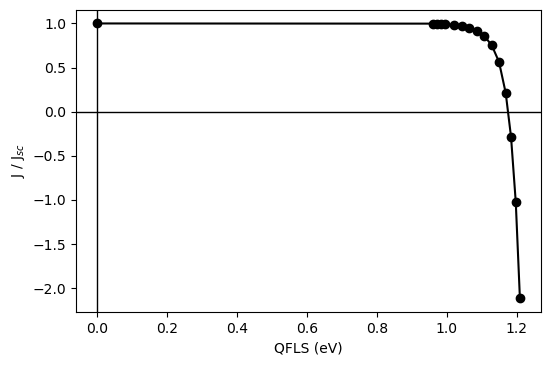

In [7]:
num_suns = powers / power_at_1sun
psudo_currents = 1 - num_suns


voc_rad0 = vocradf(bandgap)
jsc_by_j0 = np.exp(sci.e*voc_rad0/(sci.k*298))-1
voc_rads = (sci.k*298/sci.e)*np.log((jsc_by_j0*num_suns)+1)

QFLSs = voc_rads + (sci.k * 298 / sci.e)*np.log(PLQE)

QFLS_zeroed, psudo_current_zeroed = ([0],[1])
for QFLS, psudo_current in zip(QFLSs, psudo_currents):
    QFLS_zeroed.append(QFLS)
    psudo_current_zeroed.append(psudo_current)


fig, ax = plt.subplots(dpi=100)
ax.plot(interpolate_gaps(QFLS_zeroed), psudo_current_zeroed, 'o-', color='k')
plt.axvline(0, color='k', linewidth=1)
plt.axhline(0, color='k', linewidth=1)


ax.set_xlabel('QFLS (eV)')
ax.set_ylabel("J / J$_{sc}$")

plt.show()